# Install Dependencies and Import Libraries

In [ ]:
!pip install faiss-gpu
!pip install transformers
!pip install pytorch-metric-learning
!pip install umap-learn
!pip install sentencepiece

In [ ]:
import numpy as np
import faiss         
from typing import List
import random
import torch
torch.set_printoptions(threshold=700)
from tqdm import tqdm
import h5py
from dataclasses import dataclass
import numpy as np
import os     
import os.path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
from functools import reduce
import math
from pprint import pprint
import umap
from cycler import cycler
np.random.seed(0)             # set the seed to make the experiments reproducible

# NLP with BERT and Transformers 

Transformer models can be used in python with the **Huggingface Transformers** (`pip install transformers`)
 library which comes with ready-to-use implementations of the SOTA models proposed in literature.

We can easily create a BERT model using the `BertModel` class. We can load pretrained weights passing 'bert-base-uncased' in the `pretrained_wights` method. This weights comes from the original BERT model which have been pretrained on Masked Language Modeling and Next Sentence Prediction tasks.

To use the models, we must also create a `tokenizer` object that is required to encode the input before it can be fed to the transformer.

Efficient Transformers like BigBird, Reformer, Transformer-XL etc... are also available



In [ ]:
from transformers import BertTokenizer, BertModel
from transformers import BigBirdTokenizer, BigBirdModel

pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)
model = BertModel.from_pretrained(pretrained_weights)

#There are also implementations available for the efficient transformer models
bigbird_pretrained_weights = 'google/bigbird-roberta-base'
bigbird_tokenizer = BigBirdTokenizer.from_pretrained(bigbird_pretrained_weights)
bigbird_model = BigBirdModel.from_pretrained(bigbird_pretrained_weights)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(f"BERT is trained for sequences up to {model.config.max_position_embeddings}")
print(f"BigBird is trained for sequences up to {bigbird_model.config.max_position_embeddings}")

BERT is trained for sequences up to 512
BigBird is trained for sequences up to 4096


In [ ]:
# input text
text = "A sample input text."

print(f"The text is tokenized into: {tokenizer.tokenize(text)}")

# split text into tokens using a tokenizer
encoded_input = tokenizer(text, return_tensors='pt')
print("the CLS and SEP tokens are added at the start and at the end of the sentence")
print(f"Each token is assigned an input id: {encoded_input['input_ids']}")

output = model(**encoded_input)

print("""
When no heads are used, the output is split in two parts: 
- The ouput relative the  special CLS token (which is usually used for calssification)
- One embbedding for each token in the sentence in input which represents a latent contextualized representation
""")

cls = output['pooler_output']
hidden_state = output['last_hidden_state']
print(f"Pooled CLS token output: {cls}, shape: {cls.shape}")
print(f"Contextualized embeddings: {hidden_state}, shape: {hidden_state.shape}")

The text is tokenized into: ['a', 'sample', 'input', 'text', '.']
the CLS and SEP tokens are added at the start and at the end of the sentence
Each token is assigned an input id: tensor([[ 101, 1037, 7099, 7953, 3793, 1012,  102]])

When no heads are used, the output is split in two parts: 
- The ouput relative the  special CLS token (which is usually used for calssification)
- One embbedding for each token in the sentence in input which represents a latent contextualized representation

Pooled CLS token output: tensor([[-0.8837, -0.3806, -0.8929,  ..., -0.8468, -0.7010,  0.8810]],
       grad_fn=<TanhBackward0>), shape: torch.Size([1, 768])
Contextualized embeddings: tensor([[[-0.7700, -0.1339, -0.6115,  ..., -0.3188,  0.1008,  0.6080],
         [-0.3071, -0.4836, -0.3850,  ..., -0.3985,  0.5804,  0.5132],
         [-0.0351, -0.4324,  0.0530,  ..., -0.5289, -0.0845, -0.2632],
         ...,
         [-0.1285, -0.0382,  0.3915,  ..., -0.4591, -0.0536,  0.2246],
         [-1.1617, -1.077

## Test BERT natural language processing power
We can use the `pipeline` utility to test BERT performance in various NLP tasks


**Masked Language Modeling**

In [ ]:
from transformers import pipeline

masked_language_modeling = pipeline("fill-mask", top_k=3)
#masked_phrase = f"I broke my leg, i had to go to the <mask>"
masked_phrase = f"The capital of France is <mask>"

pprint(masked_language_modeling(masked_phrase))

No model was supplied, defaulted to distilroberta-base (https://huggingface.co/distilroberta-base)


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

[{'score': 0.15007759630680084,
  'sequence': 'The capital of France is Paris',
  'token': 2201,
  'token_str': ' Paris'},
 {'score': 0.028450636193156242,
  'sequence': 'The capital of France is Barcelona',
  'token': 4612,
  'token_str': ' Barcelona'},
 {'score': 0.021013623103499413,
  'sequence': 'The capital of France is pictured',
  'token': 7092,
  'token_str': ' pictured'}]


**Sentiment Analysis**

In [ ]:
# Allocate a pipeline for sentiment-analysis
classifier = pipeline('sentiment-analysis')
classifier("The film was horrible")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

[{'label': 'NEGATIVE', 'score': 0.9997871518135071}]

**Question Answering**

In [ ]:
question_answering = pipeline("question-answering")
context = """
Machine learning (ML) is the study of computer algorithms that improve automatically through experience. 
It is seen as a part of artificial intelligence. Machine learning algorithms build a model based on sample data, 
known as "training data", in order to make predictions or decisions without being explicitly programmed to do so. 
Machine learning algorithms are used in a wide variety of applications, such as email filtering and computer vision, 
where it is difficult or unfeasible to develop conventional algorithms to perform the needed tasks.
"""

question = "What are the applications of machine learning?"
#question = "What are machine learning models based on?"

result = question_answering(question=question, context=context)
print("Answer:", result['answer'])
print("Score:", result['score'])

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Answer: email filtering and computer vision
Score: 0.963866651058197


# Metric Learning

## Utility Code

In [ ]:
#@title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class CNN(nn.Module):
    def __init__(self, embedding_dim = 128):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.fc1 = nn.Linear(21632, embedding_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}:  Number of mined triplets = {}".format(
                    epoch, batch_idx, mining_func.num_triplets
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

def visualize_embeddings(embeddings_reduced, labels):
  label_set = np.unique(labels)
  num_classes = len(label_set)
  fig = plt.figure(figsize=(20, 15))
  plt.gca().set_prop_cycle(
      cycler(
          "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
      )
  )
  for i in range(num_classes):
      idx = (labels == label_set[i])
      plt.plot(embeddings_reduced[idx, 0], embeddings_reduced[idx, 1], ".", markersize=1,label=i)
  plt.legend(loc='best',markerscale=10)
  plt.show()

## Metric Learning on MNIST

We will try to train a CNN model on the MNIST dataset to **recognize handwritten digits using Triplet Loss**.

<img src="https://miro.medium.com/max/1400/1*E6UUEmxKp5ZTRgCRNbIP-g.png" alt="metric learning mnist" width="300"/>


We will use the **pytorch-metric-learning** library (`pip install pytorch-metric-learning`)




In [ ]:
from torchvision import datasets, transforms

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


device = torch.device("cuda")

mnist_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.RandomErasing(p=0.35)]
)

batch_size = 256

# load mnist train and test set
dataset1 = datasets.MNIST(".", train=True, download=True, transform=mnist_transform)
dataset2 = datasets.MNIST(".", train=False, transform=mnist_transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=256)

# initialize CNN model
embedding_dim = 32
model = CNN(embedding_dim).to(device)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



We can try to visualize the latent space before training the model. We use a dimensionality reduction algorithm to reduce embeddings from $\mathbb{R}^{32}$ to $\mathbb{R}^{2}$. We will use **UMAP** (t-SNE could also be used).

In [ ]:
embeddings, labels = get_all_embeddings(dataset2, model) # get MNIST test embeddings
umap_visualizer = umap.UMAP()

# reduce dimensionality to 2-D using UMAP
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())
labels = labels.cpu().numpy().flatten()

100%|██████████| 313/313 [00:03<00:00, 99.46it/s] 
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


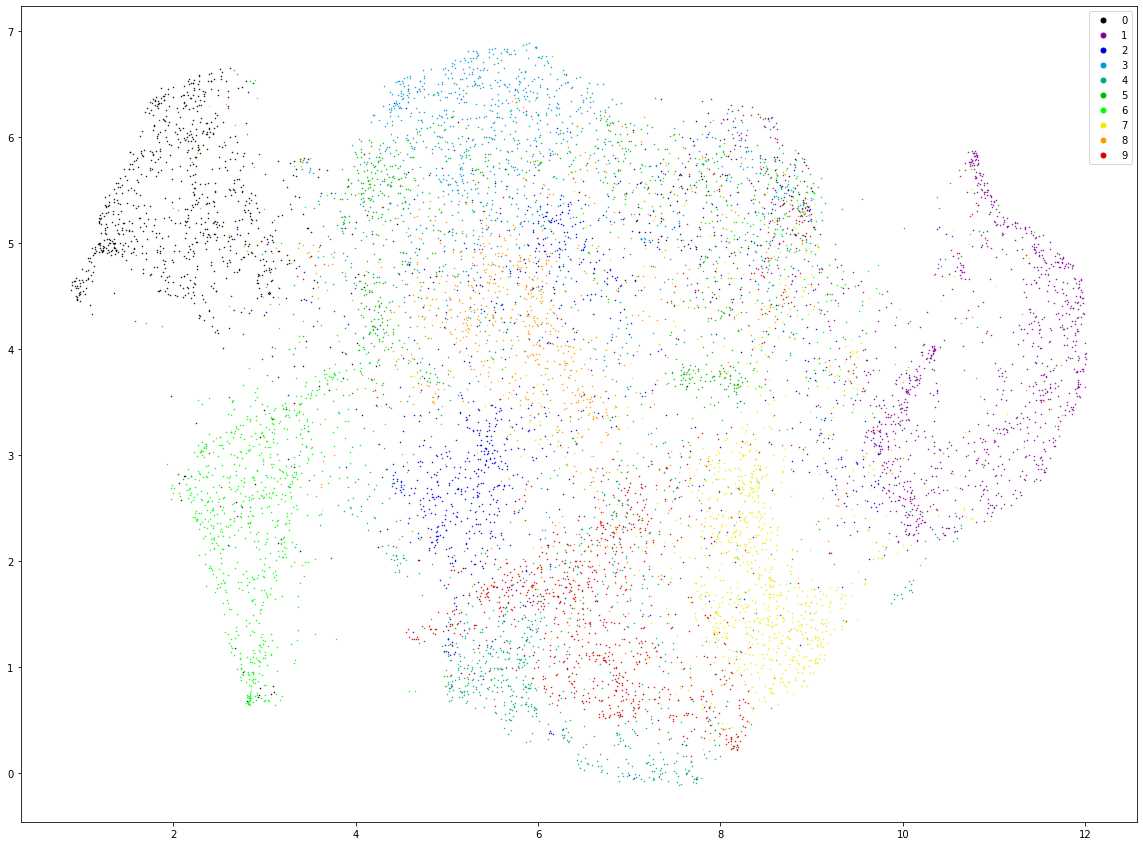

In [ ]:
visualize_embeddings(embeddings_reduced, labels)

In [ ]:
### metric-learning stuff ###
optimizer = optim.Adam(model.parameters(), lr=0.01)

margin = 0.1
loss_func = losses.TripletMarginLoss(margin=margin) # triplet loss with margin 0.1
mining_func = miners.TripletMarginMiner(margin=margin, type_of_triplets="semihard") # use semihard mining
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

num_epochs = 1 # train for 1 epoch

for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0:  Number of mined triplets = 404443
Epoch 1 Iteration 20:  Number of mined triplets = 106866
Epoch 1 Iteration 40:  Number of mined triplets = 58148
Epoch 1 Iteration 60:  Number of mined triplets = 55242
Epoch 1 Iteration 80:  Number of mined triplets = 40371
Epoch 1 Iteration 100:  Number of mined triplets = 32016
Epoch 1 Iteration 120:  Number of mined triplets = 37878
Epoch 1 Iteration 140:  Number of mined triplets = 35687
Epoch 1 Iteration 160:  Number of mined triplets = 29795
Epoch 1 Iteration 180:  Number of mined triplets = 29371
Epoch 1 Iteration 200:  Number of mined triplets = 30117
Epoch 1 Iteration 220:  Number of mined triplets = 31814


100%|██████████| 313/313 [00:02<00:00, 106.64it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.925


We can now visualize the new latent space

In [ ]:
embeddings, labels = get_all_embeddings(dataset2, model)
umap_visualizer = umap.UMAP()

# reduce dimensionality from 128 to 2-D
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())
labels = labels.cpu().numpy().flatten()

100%|██████████| 313/313 [00:02<00:00, 107.42it/s]


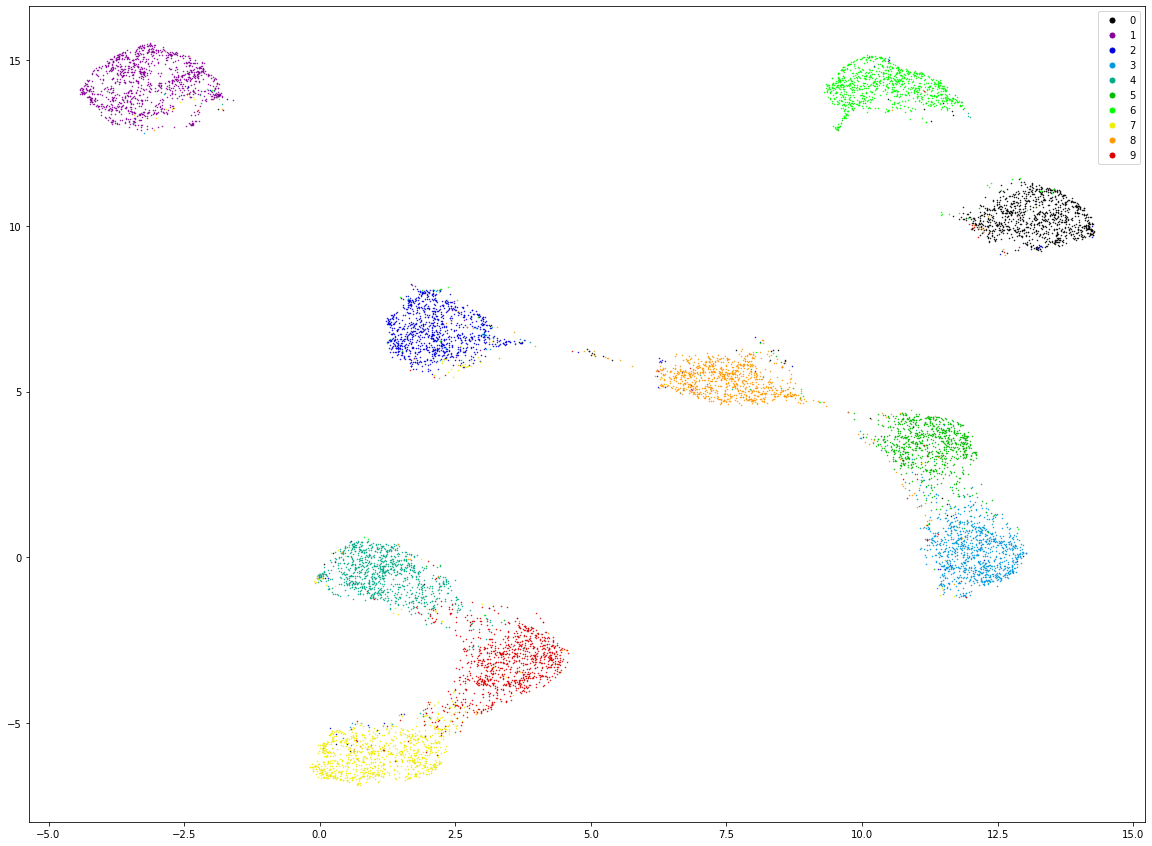

In [ ]:
visualize_embeddings(embeddings_reduced, labels)

# Efficient Retrieval with Faiss


Once you have a trained model that can generate embeddings (of text or images), it is important to find a way to use this embeddings efficiently, expecially in retrieval scenarios.

In python efficient algorithms to work with embeddings are available through the **faiss** library.

We can first run some experiments on a sample database with random embeddings. We will generate a database of $N=10^6$ embeddings in $\mathbb{R}^{256}$.

In [ ]:
d = 256       # dimension
N = 1000000   # database size

dataset_embeddings = np.random.random((N, d)).astype('float32')
print(dataset_embeddings.shape, dataset_embeddings)

(1000000, 256) [[0.7633656  0.645719   0.8173778  ... 0.32732755 0.6369052  0.05117289]
 [0.86437035 0.7083596  0.12457423 ... 0.9395355  0.39946714 0.59738505]
 [0.00951551 0.75508666 0.69089496 ... 0.3547262  0.238015   0.23719966]
 ...
 [0.59282905 0.6648086  0.33801514 ... 0.66881335 0.97337085 0.668451  ]
 [0.0248198  0.96198744 0.34470898 ... 0.6550257  0.8483844  0.2755011 ]
 [0.9844046  0.71146625 0.5782243  ... 0.41521612 0.3311404  0.12587392]]


Next we must generate some sample queries, which are also embeddings in $\mathbb{R}^{256}$. We will use $Q=500$ queries

In [ ]:
Q = 500
query_embeddings = np.random.random((Q, d)).astype('float32')

## Naive K-NN Search

The performer retrieval in Faiss we must first create an `Index` object for our dataset. For our first example we are going to use the simplest version that just performs naive L2 distance search: `IndexFlatL2`.

In [ ]:
l2_index = faiss.IndexFlatL2(d)  # each index must know the dimensionality of the embeddings
print(l2_index.is_trained) # some indices require a training phase but this is not the case for FlatL2 index; this line should return true
l2_index.add(dataset_embeddings) # add vectors to the index
print(l2_index.ntotal)

True
1000000


You can use the `search` method must be used to run nearest neighbor retrieval search. You should also specify the number $k$ of results to retrieve. 

We will set $k=5$ so that we will have the top-5 results for each query.

The `search` method returns two results: the distances matrix $D \in \mathbb{R}^{Q \times k}$ and the indices matrix $I \in \mathbb{N}_{+}^{Q \times k}$. The first one contains the distance between the queries and the top-$k$ results; the latter containes the indices of the retrieved embeddings in the dataset.






In [ ]:
k = 5                                     # we want to find top-5 nearest neighbors
L2_D, L2_I = l2_index.search(query_embeddings, k)  # actual search

check_queries = 5
print(f"D shape: {L2_D.shape}, I shape: {L2_I.shape}\n")
print(f"Indices of the nearest neighbors of the first {check_queries} queries\n{L2_I[:check_queries]}\n") 

print(f"The distances between the first query and its nearest neighbors are {L2_D[0, :]}\n")

D shape: (500, 5), I shape: (500, 5)

Indices of the nearest neighbors of the first 5 queries
[[213250 221228 954905 917983 722163]
 [497468 246592 729525 228576 383586]
 [626280 475863 184074 591365 323376]
 [ 73909 332189 489393 867290 278276]
 [351261 364801  15004 198858 548659]]

The distances between the first query and its nearest neighbors are [28.916733 29.777786 29.840775 29.86406  30.204376]



To check that our index is working correctly, we can take the first 3 embeddings in the dataset and use them as queries. We expect that the index will correctly find the embedding itself as the top result, so we should have that:
1. The first entries for each query in the $I$ matrix have indices $[0,1,2]$  
2. The distance between the query and its top  result is $0$

In [ ]:
n = 3
D, I = l2_index.search(dataset_embeddings[:n], k)

print("Sanity Check:")
print(I)
assert np.equal(I[:,0], np.arange(n)).all()

print(D)
assert np.equal(D[:,0], np.zeros(n)).all()

print("Check OK!")

Sanity Check:
[[     0 385960 788911 348311 198573]
 [     1 501900 546177 446339 216472]
 [     2 337003 848362  63605 489762]]
[[ 0.       29.53181  30.240513 30.500097 30.53446 ]
 [ 0.       30.707094 30.800474 30.908054 31.095451]
 [ 0.       29.797535 29.855719 30.10633  30.227633]]
Check OK!


We can measure the time required to perform the search 

In [ ]:
def avg_search_time(index: faiss.Index, queries:np.ndarray, k:int, num_iterations:int = 5):
  start = time.time()
  partial = start
  for i in tqdm(range(num_iterations), position=0, leave=True): # run num_iterations searches and take the average
    index.search(queries, k)
    partial=time.time()

  elapsed = time.time()-start
  return elapsed/num_iterations


l2_avg_time = avg_search_time(l2_index, query_embeddings, k, num_iterations=5)
print(f"Average time for Naive Search on CPU: {l2_avg_time}")

100%|██████████| 5/5 [00:30<00:00,  6.02s/it]

Average time for Naive Search on CPU: 6.022216892242431


## Inverted File Index (IVF)

Faiss also provides approximate nearest neighbor search algorithms.

The **Inverted File Index (IVF)** defines Voronoi cells in the d-dimensional space, and each database vector falls in one of the cells. At search time, only the database vectors $y$ contained in the cell the query $x$ falls in and a few neighboring ones (called `probes`) are compared against the query vector. The number of cells $k'$ is configurable

The number of probes can be configured using the `nprobe` parameter. This is a way of adjusting the tradeoff between speed and accuracy of the result. Setting `nprobe` = $k'$ gives the same result as the brute-force search (but slower).

The figure below show an example for a query $x$ with $k'=64$ and `nprobes=4`

<img src="https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/6287639/8600701/8653810/wang3-2900730-large.gif" alt="Nearest neighbor retrieval with inverted file index. nprobes=4, k'=64" width="450"/>

IVF can be used in faiss through the `IndexIVFFlat` class. This type of index requires a training stage, that can be performed on any collection of vectors that has the same distribution as the database vectors. Usually the database vectors themselves are used.

This index also requires another index, the **quantizer**, that assigns vectors to Voronoi cells. Each cell is defined by a centroid, and finding the Voronoi cell a vector falls in consists in finding the nearest neighbor of the vector in the set of centroids. This is the task of the other index, which is typically an `IndexFlatL2`.

In [ ]:
k_prime = 100 # number of voronoi cells
k = 5 # we want to find top-5 nearest neighbors
nprobe = 1 # number of probes, faiss use 1 as default

quantizer = faiss.IndexFlatL2(d) # index that assign embedding to voronoi cells
ivf_index = faiss.IndexIVFFlat(quantizer, d, k_prime) # main index used to perform retrieval


assert not ivf_index.is_trained                       
ivf_index.train(dataset_embeddings) # train the index (i.e. subdivided the space into cells)
assert ivf_index.is_trained

ivf_index.nprobe = nprobe  
ivf_index.add(dataset_embeddings) # add may be slowwer than the L2 index
IVF_D, IVF_I = ivf_index.search(query_embeddings, k) # actual search
print(f"Indices of the nearest neighbors of the first {check_queries} queries\n{IVF_I[:check_queries]}\n") 

print(f"The distances between the first query and its nearest neighbors are {IVF_D[0, :]}\n")


Indices of the nearest neighbors of the first 5 queries
[[531590 871753 344277 236174 914499]
 [170474 762934 622355 948579  81784]
 [591365   3308 638003 193812 102631]
 [237629 477477 207359 715940 625320]
 [561132 809666 671645 766817  35973]]

The distances between the first query and its nearest neighbors are [31.857325 32.37171  32.567005 32.784126 32.881233]



Check how much time it requires to find top-k results with IVF index

In [ ]:
ivf_avg_time = avg_search_time(ivf_index, query_embeddings, k, num_iterations=5)
print(f"Average time for IVF index: {ivf_avg_time}")

100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

Average time for IVF index: 1.0872745990753174


Let's try using a higher `nprobe` value

In [ ]:
nprobes = 3
ivf_index.nprobe = nprobes
ivf_avg_time = avg_search_time(ivf_index, query_embeddings, k, num_iterations=5)

print(f"Average time for IVF index: {ivf_avg_time}")

100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

Average time for IVF index: 3.2205716609954833


We can compare the results of the IVF index and the L2 Naive index

In [ ]:
print(f"Results of the L2 index for the first {check_queries} queries\n{L2_I[:check_queries]}\n") 
print(f"Results of the IVF index for the first {check_queries} queries\n{IVF_I[:check_queries]}\n") 

Results of the L2 index for the first 5 queries
[[213250 221228 954905 917983 722163]
 [497468 246592 729525 228576 383586]
 [626280 475863 184074 591365 323376]
 [ 73909 332189 489393 867290 278276]
 [351261 364801  15004 198858 548659]]

Results of the IVF index for the first 5 queries
[[531590 871753 344277 236174 914499]
 [170474 762934 622355 948579  81784]
 [591365   3308 638003 193812 102631]
 [237629 477477 207359 715940 625320]
 [561132 809666 671645 766817  35973]]



## PCA Reduction
To further improve performance one can also reduce the dimensionality of the embeddings before adding them to the index. This can be done in fass using Principal Component Analysis. We will try to perform naive nearest neighbor retrieval reducing the dimensionality from $d=256$ to $d'=32$.

The idea therefore is to combine two operations: first, we want to reduce embeddings dimensions, second we want to create a IndexL2 on the reduced embeddings.

To facilitate the construction of these type index structures, faiss provides the `index_factory` method which interprets a string to produce a composite Faiss index.

In our case we will set `index = index_factory(256, "PCA32,Flat")`.
`Flat` indicates the exhaustive search with `IndexL2`.

In [ ]:
from faiss import index_factory

d_prime = 32
pca_index = index_factory(d, f"PCA{d_prime},Flat")
pca_index.train(dataset_embeddings)
pca_index.add(dataset_embeddings)

PCA_D, PCA_I = pca_index.search(query_embeddings, k) # actual search
print(f"Indices of the nearest neighbors of the first {check_queries} queries\n{PCA_I[:check_queries]}\n") 

print(f"The distances between the first query and its nearest neighbors are {PCA_D[0, :]}\n")

Indices of the nearest neighbors of the first 5 queries
[[305707 470130 343239 580761 221779]
 [902252 649631 501890 160333 895421]
 [477976 332370  75539 733987 807250]
 [220885 495517  48816 461420 800487]
 [390260 762330 362879 411189 906822]]

The distances between the first query and its nearest neighbors are [1.1649661 1.2078619 1.2279015 1.2704866 1.3339233]



In [ ]:
print(f"Results of the L2 index for the first {check_queries} queries\n{L2_I[:check_queries]}\n") 
print(f"Results of the PCA index for the first {check_queries} queries\n{PCA_I[:check_queries]}\n") 

Results of the L2 index for the first 5 queries
[[213250 221228 954905 917983 722163]
 [497468 246592 729525 228576 383586]
 [626280 475863 184074 591365 323376]
 [ 73909 332189 489393 867290 278276]
 [351261 364801  15004 198858 548659]]

Results of the PCA index for the first 5 queries
[[305707 470130 343239 580761 221779]
 [902252 649631 501890 160333 895421]
 [477976 332370  75539 733987 807250]
 [220885 495517  48816 461420 800487]
 [390260 762330 362879 411189 906822]]



In [ ]:
pca_avg_time = avg_search_time(pca_index, query_embeddings,k,num_iterations=5)
print(f"Average time for PCA index: {pca_avg_time}")

100%|██████████| 5/5 [00:09<00:00,  1.88s/it]

Average time for PCA index: 1.8799895286560058


## GPU vs CPU

Faiss supports GPU computation. The GPU usually represents a significant speedup over the CPU implementations. We can access GPU through the `faiss.StandardGpuResources()` class.

In [ ]:
res = faiss.StandardGpuResources() 

And we can move indices to GPU using the `index_cpu_to_gpu`.

In [ ]:
k = 100                               # find top k results

gpu_index_l2 = faiss.IndexFlatL2(d)   # create an index FlatL2 index
gpu_index_l2.add(dataset_embeddings) # add vectors to the index
gpu_index_l2 = faiss.index_cpu_to_gpu(res, 0, gpu_index_l2) # move the index on the gpu

gpu_index_l2_avg_time = avg_search_time(gpu_index_l2, query_embeddings,k, num_iterations=5)
print(f"Average time for GPU L2 index: {gpu_index_l2_avg_time}")

100%|██████████| 5/5 [00:00<00:00,  5.25it/s]

Average time for GPU L2 index: 0.19145655632019043


## Exercise 1

Create an IVF index and PCA index and move them to the GPU, then compute the average time required to perform the queries

In [ ]:
# code here

In [ ]:
#@title Solution
k_prime = 100 # number of voronoi cells
k = 5 # we want to find top-5 nearest neighbors
nprobe = 1 # number of probes, faiss use 1 as default

quantizer = faiss.IndexFlatL2(d) # index that assign embedding to voronoi cells
gpu_ivf_index = faiss.IndexIVFFlat(quantizer, d, k_prime) # main index used to perform retrieval
gpu_ivf_index.train(dataset_embeddings) # train the index (i.e. subdivided the space into cells)
gpu_ivf_index = faiss.index_cpu_to_gpu(res, 0, gpu_ivf_index) # move the index on the gpu

gpu_ivf_index.nprobe = nprobe  
gpu_ivf_index.add(dataset_embeddings) # add may be slowwer than the L2 index
gpu_index_ivf_avg_time = avg_search_time(gpu_ivf_index, query_embeddings, k, num_iterations=5)
print(f"Average time for GPU IVF index: {gpu_index_ivf_avg_time}")

d_prime = 32
gpu_pca_index = index_factory(d, f"PCA{d_prime},Flat")
gpu_pca_index.train(dataset_embeddings)
gpu_pca_index.add(dataset_embeddings)
gpu_pca_index = faiss.index_cpu_to_gpu(res, 0, gpu_pca_index) # move the index on the gpu
gpu_pca_index_avg_time = avg_search_time(gpu_pca_index, query_embeddings, k, num_iterations=5)

print(f"Average time for GPU PCA index: {gpu_pca_index_avg_time}")


100%|██████████| 5/5 [00:00<00:00, 29.99it/s]


Average time for GPU IVF index: 0.03438382148742676


100%|██████████| 5/5 [00:00<00:00, 16.86it/s]

Average time for GPU PCA index: 0.06034054756164551


# Test on a Real Dataset (FashionGen)

## Dataset Utils

In [ ]:
"""
FashionGen strings encoding
"""
DEFAULT_STRINGS_ENCODING = "ISO-8859-9"

@dataclass
class Product:
    p_id:int
    name:str = ""
    caption:str = ""
    concat_caption:str = ""
    image:np.ndarray = None
    category:str = ""
    subcategory:str = ""
    composition:str = ""
    department:str = ""
    gender:str = ""
    msrpUSD: float = 0
    season: str = ""
    brand:str = ""
    pose:str = "id_gridfs_1"
    index:int =-1
    caption_embedding: np.ndarray = None
    image_embedding: np.ndarray = None


    def __lt__(self, other):
        return self.p_id < other.p_id

    def __eq__(self, other):
        return self.p_id == other.p_id and self.pose == other.pose

    def __hash__(self):
        return hash((self.p_id, self.pose))

    def __str__(self):
      return os.linesep.join([f"{a}: {v}" for a,v in self.__dict__.items() if isinstance(v, str) or isinstance(v,float)])


class FashionGenDataset:
    def __init__(self, file_name):
        self.__subcategory_dict = None
        self.__productid_dict = None
        self.__category_dict = None
        self.__loaded_products = []
        self.__products_lodaded = False
        self.dataset = h5py.File(file_name, mode="r")

    def __getitem__(self, index):
        if isinstance(index, slice):
            return [
                self.get_product(i)
                for i in tqdm(
                    range(
                        min(self.length(), index.start),
                        min(self.length(), index.stop),
                        index.step if index.step is not None else 1,
                    )
                )
            ]
        else:
            return self.get_product(index)

    def __len__(self):
        return self.length()

    def load_products(self):
        """Load all products in a python array."""
        if not self.__products_lodaded:
            print("Loading products...")
            self.__loaded_products = [self.get_product(i) for i in tqdm(range(self.length()))]
            self.__products_lodaded = True

    def length(self):
        return len(self.dataset["input_productID"])

    def distinct_products_in_subcategory(self, subcategory: str):
        return set([p_id for _, p_id in self.subcategory_dict()[subcategory]])

    def distinct_products_in_category(self, category: str):
        return set([p_id for _, p_id in self.category_dict()[category]])

    def raw_h5(self):
        return self.dataset

    def close_file(self):
        self.dataset.close()

    def get_pid_of(self, index):
      return self.dataset["input_productID"][index][0]

    def get_product(self, index, string_encoding = DEFAULT_STRINGS_ENCODING):
        """Return the product in the dataset at the specified index"""
        if self.__products_lodaded:
            return self.__loaded_products[index]
        else:
            return Product(
                p_id=self.dataset["input_productID"][index][0], 
                name=self.dataset["input_name"][index][0].decode(string_encoding), 
                caption=self.dataset["input_description"][index][0].decode(string_encoding),
                #concat_caption=self.dataset["input_concat_description"][index][0].decode(string_encoding), 
                image=self.dataset["input_image"][index], 
                category=self.dataset["input_category"][index][0].decode(string_encoding), 
                subcategory=self.dataset["input_subcategory"][index][0].decode(string_encoding), 
                pose=self.dataset["input_pose"][index][0].decode(string_encoding), 
                #composition = self.dataset["input_composition"][index][0].decode(string_encoding),
                #department = self.dataset["input_department"][index][0].decode(string_encoding),
                #gender =  self.dataset["input_gender"][index][0].decode(string_encoding),
                #msrpUSD = float(self.dataset["input_msrpUSD"][index][0]),
                #season = self.dataset["input_season"][index][0].decode(string_encoding),
                #brand = self.dataset["input_brand"][index][0].decode(string_encoding),
                index=index
            )

    def get_product_by_id(self, product_id: int, get_random: bool = False):
        """
        Get the product with the specified product id.
        The image of the product is the first one that appears in the dataset if get_random is set to False, Otherwise a random one is selected
        Args:
            product_id: the id of the product to get
            get_random: if False, the first image of the product will be returned, otherwise a random one is selected
        """
        product_indexes = self.productID_dict()[product_id]
        index = random.choice(product_indexes) if get_random else product_indexes[0]
        return self.get_product(index)

    def subcategory_dict(self) -> dict:
        """A dictionary that foreach 'subcategory' keeps a list of products (and indexes)
        that belong to it"""
        if self.__subcategory_dict is None:
            self.__subcategory_dict = self.__create_attribute_dict("input_subcategory")

        return self.__subcategory_dict

    def category_dict(self) -> dict:
        """A dictionary that foreach 'category' keeps a list of products (and indexes)
        that belong to it"""
        if self.__category_dict is None:
            self.__category_dict = self.__create_attribute_dict("input_category")
        return self.__category_dict

    def productID_dict(self) -> dict:
        """A dictionary that foreach productID keeps the list of indexes in the dataset where those products can be found"""
        if self.__productid_dict is None:
            self.__productid_dict = self.__create_productID_dict()
        return self.__productid_dict

    def get_random_product(self, id_different_from: int = None) -> Product:
        """
        Return a random product from the dataset
        Args:
            id_different_from: an id of a product that cannot be taken. Use None if any products can be returned
        Returns:
            A random product with an id different from 'id_different_from' (if specified)
        """
        random_product = self[random.choice(range(self.length() - 1))]
        while id_different_from is not None and random_product.p_id == id_different_from:
            random_product = self[random.choice(range(self.length() - 1))]
        return random_product

    def get_random_products(self, id_different_from: int = None, n: int = 1) -> List[Product]:
        """
        Get a list of random products
        Args:
            id_different_from: an id of a product that cannot be taken. Use None if any products can be returned
            n: number of products to return
        Returns:
            A list of n products with product ids different from id_different_from (is specified)
        """
        # we don't call the 'get_random_product' function n times because we want to avoid taking the same product (and image)
        # multiple times.
        random_indexes = random.sample(range(self.length() - 1), n)
        random_products = [self[index] for index in random_indexes]
        # replace all products that have id equals to id_different_from with other random ones.
        # It can happen after this step that the same negative product is repeated
        random_products = map(
            lambda p: self.get_random_product(id_different_from)
            if id_different_from is not None and p.p_id == id_different_from
            else p,
            random_products,
        )
        return list(random_products)

    def get_same_subcategory_of(self, product: Product, n: int = 1) -> List[Product]:
        """
        Get a list of random products with the same subcategory of the given product (but with different product ids).
        If the given subcategory has less products than the number n specified, some random product will be returned
        Args:
            product: the product for which we want to find other ones with the same subcategory
            n: The number of products to return
        Returns:
            A list of n products with different ids but same subcategory of the given one.

        """
        negative_prods_idxs = [
            index for index, p_id in self.subcategory_dict()[product.subcategory] if p_id != product.p_id
        ]
        return self.__get_random_products_by_indexes(negative_prods_idxs, product.p_id, n)

    def get_same_category_of(self, product: Product, n: int = 1) -> List[Product]:
        """
        Get a list of random products with the same category of the given product (but with different product ids).
        If the given category has less products than the number n specified, some random product will be returned
        Args:
            product: the product for which we want to find other ones with the same category
            n: The number of products to return
        Returns:
            A list of n products with different ids but same category of the given one.
        """
        negative_prods_idxs = [index for index, p_id in self.category_dict()[product.category] if p_id != product.p_id]
        return self.__get_random_products_by_indexes(negative_prods_idxs, product.p_id, n)

    def __get_random_products_by_indexes(
        self, indexes: List[int], id_different_from: int = None, n: int = 1
    ) -> Product:
        """
        Return a given number of products randomly sampling indexes from a given list. If the number 'n' specified
        is bigger the number of indexes, other random products will be takens (with ids different from 'id_different_from')
        """
        if len(indexes) >= n:
            return [self.get_product(idx) for idx in random.sample(indexes, n)]
        else:
            return self.__get_random_products_by_indexes(
                indexes, id_different_from, len(indexes)
            ) + self.get_random_products(id_different_from, n - len(indexes))

    def get_batch(self, features, from_index, to_index):
        """Get a batch of the raw h5 dataset

        Args:
            features(list(str)): list of names of features present in the dataset
                that should be returned.
            batch_number(int): the id of the batch to be returned.
            batch_size(int): the mini-batch size
        Returns:
            A list of numpy arrays of the requested features"""
        batch = {}
        for feature in features:
            batch[feature] = self.dataset[feature][from_index:to_index]
        return batch

    def __create_productID_dict(self):
        print(f"Creating productID dictionary...")
        prodID_to_index = {}
        for i in tqdm(range(self.length()), position=0, leave=True):
            prod_id = self.dataset["input_productID"][i][0]
            if prod_id in prodID_to_index:
                prodID_to_index[prod_id].append(i)
            else:
                prodID_to_index[prod_id] = [i]
        return prodID_to_index

    def __create_attribute_dict(self, attribute):
        print(f"Creating {attribute} dictionary...")
        attribute_to_prod = {}
        for i in tqdm(range(self.length()), position=0, leave=True):
            attribute_value = self.dataset[attribute][i][0]
            prod_id = self.dataset["input_productID"][i][0]
            if attribute_value in attribute_to_prod:
                # indexes = attribute_to_prod[attribute_value]
                # if (prod_id not in [p for i, p in indexes]):
                attribute_to_prod[attribute_value].append((i, prod_id))
            else:
                attribute_to_prod[attribute_value] = [(i, prod_id)]
        return attribute_to_prod


## Visualization Utils

In [ ]:
def visualize_product_images(products: List[Product], n_cols = 5, highlight_id = None):
  """
  Utility function to visualize product images with matplotlib
  """
  fig = plt.figure(figsize=(32, 32))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(len(products)//n_cols, n_cols),  # creates 2x2 grid of axes
                  axes_pad=0.1,  # pad between axes in inch.
                  )
  
  for ax, p in zip(grid, products):
      ax.imshow(p.image)
      ax.set_xticks([])
      ax.set_yticks([])
      if p.p_id==highlight_id:
        for s in ax.spines:
          ax.spines[s].set_color('green')
          ax.spines[s].set_linewidth(3.5)


def imscatter(x, y, images, ax=None, zoom=1):
  if ax is None:
    ax = plt.gca()
  artists = []
  for x0, y0, i in zip(x, y, images):
    im = OffsetImage(i, zoom=zoom)
    #x, y = np.atleast_1d(x, y)
    ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
    ab.set_zorder(-2)
    artists.append(ax.add_artist(ab))
  ax.update_datalim(np.column_stack([x, y]))
  ax.autoscale()
  return artists

## Download Dataset

In [ ]:
if not os.path.isfile("caption_embeddings.npy"):
  !gdown --id 1NcvbkfI5HeE3sxIZzQReXY0HzJ8px8vq # caption embeddings

if not os.path.isfile("image_embeddings.npy"):
  !gdown --id 1LUszAI6nHe2Cs2M2ouzY7WpkQhtLJ6c_ # image embeddings

if not os.path.isfile("fashiongen_256_256_validation.h5"):
  !gdown --id 1n9Zknl6EMpClb_w6dEdxsCdCV2uD9oiX # validation dataset

In [ ]:
dataset = FashionGenDataset("fashiongen_256_256_validation.h5")
dataset.productID_dict()
#dataset.load_products()
print("done.")

Creating productID dictionary...


100%|██████████| 32528/32528 [00:29<00:00, 1111.35it/s]

done.


## Load Embeddings

We load caption and image embeddings from file. These are embeddings generated from the FashionGen validation dataset using a Vision-and-Language transformer trained with metric learning. 

The dataset contains 7519 distinct products. Each product can have up to 6 different images taken at different angles with the same description. There are a total of 32528 images.

In [ ]:
caption_embeddings = np.load("caption_embeddings.npy")
image_embeddings = np.load("image_embeddings.npy")
product_ids = np.array([dataset.get_pid_of(i) for i in tqdm(range(len(image_embeddings)))]).astype(np.int64)

print(f"""
There are 
  {len(caption_embeddings)} caption embeddings
  {len(image_embeddings)} image embeddings 
  with dimension: {caption_embeddings.shape[1]}
""")
print(f"The number of distinct products is {len(set(product_ids))}")

100%|██████████| 32528/32528 [00:22<00:00, 1468.27it/s]


There are 
  32528 caption embeddings
  32528 image embeddings 
  with dimension: 768

The number of distinct products is 7519


## Text to Image Retieval

For **Text-to-Image Retrieval** we will take $Q=200$ random captions as queries and we will use the 32528 images as documents.

In [ ]:
np.random.seed(1)

Q = 200
indices = np.random.choice(caption_embeddings.shape[0], size=Q, replace=False) # select indices
query_embeddings = caption_embeddings[indices] # get caption embeddings
queries_text = [dataset[i].caption for i in indices] # get caption texts for visualization
queries_ids = [dataset[i].p_id for i in indices] # get product ids of the queries to test results

Print some queries

In [ ]:
for i, q in enumerate(queries_text[:5]):
  print(i, q)

0 Short sleeve cotton jersey t-shirt in white. Rib knit crewneck collar. Multicolor logo graphic printed at front and sleeve. Tonal stitching.
1 Slip-on twill platform sneakers in navy. Round toe. Padded heel collar. Textured rubber sole in white featuring rubberized logo in black at heel. Leather lining in black. Tonal stitching. Approx. 1.5" platform.
2 Short sleeve stretch twill shirt in black. Spread collar. Button closure at front. Patch pocket at chest. Modified tennis-tail hem. Tonal stitching.
3 Slim-fit denim shorts in 'kenmare' white. Distressing and stain effect throughout. Five-pocket styling. Gusseted inseam. Leather logo patch in white at back waistband. Button-fly. Silver-tone hardware. Tonal stitching.
4 Straight-leg garment-pleated trousers in light grey. Mid-rise. Belt loops at elasticized waistband. Button-fly. Tonal stitching.


Create a naive FlatL2 index for image embeddings.

Differently from the previous examples, here **we want to associate each embedding with its product id** and not with its index in the list (indeed this is what is usually done in real scenarios where you need to access products in a database through their identifier). Faiss allows to do that with the `add_with_ids(embeddings, ids)` method.

In order to use this methods on a `FlatL2Index`, we must create it with the index_factory using the following parameter `"IDMap, Flat"`. `IDMap` tells faiss backend to map indexes to ids.

In [ ]:
d = image_embeddings.shape[1] # dimension of the embeddings (i.e. 768)
index = faiss.index_factory(d, "IDMap,Flat")

# associate each embedding with its product_id
index.add_with_ids(image_embeddings, product_ids)

# try moving the index on GPU to speed up retrieval
try:
  res = faiss.StandardGpuResources() 
  index = faiss.index_cpu_to_gpu(res, 0, index)
except:
  print("GPU not available!")

We can find the top-100 results using the `search` method and setting $k=100$

In [ ]:
k = 100
# SEARCH
start = time.time()
D,I = index.search(query_embeddings, k)
print(f"Result found in {time.time()-start} seconds")

Result found in 0.01550912857055664 seconds


Compute $Rank@K$ (K=1, 5, 10, 30, 100), which is the percentage of times the correct images is selected among the first K results. For instance, if we have $Rank@1=10\%$, it means that the correct image has been selected as the top-1 result 10% of the times. Another useful metric can be the $R\_Sum$, which is the sum of all Rank@K,   $R\_Sum=Rank@1 + Rank@5 \dots + = \sum_k Rank@k$

In [ ]:
def compute_rank_at_k(query_ids, result, Ks) -> dict:
  """
    Compute Rank@K metric for different Ks. 
    Parameters
    -----------
    query_ids: the product ids of the queries
    result: The retrieved ids for each query
    Ks: the different values of K to use
  """
  fount_at_top_k = {k: 0 for k in Ks}
  for q,r in zip(query_ids, result):
    indicator = (r==q).astype(np.int32)
    for j, label in enumerate(indicator):
      if label:
        fount_at_top_k = {k: v + (1 if k >= j + 1 else 0) for k, v in fount_at_top_k.items()}
        break  
  return {k: v/len(query_ids) for k,v in fount_at_top_k.items()}

def r_sum(rank_at_k: dict) -> float:
  """
  Compute the sum of all Rank@K accuracies in the input dictionary
  """
  return reduce(lambda a,b: a+b, rank_at_k.values())

def print_result(rank_at_k: dict) -> None:
  """
  Print Rank@K results
  Parameters
  -----------
  rank_at_k: a dictionary that maps K to the corresponding accuracy value
  """
  for k, acc in rank_at_k.items():
    print(f"Rank@{k}={acc*100}%")

  print(f"R_Sum={r_sum(rank_at_k)*100}")

# Actual computation
Ks = [1, 3, 5, 10, 30, 100]
rank_at_k = compute_rank_at_k(queries_ids, I, Ks)
print_result(rank_at_k)

Rank@1=24.0%
Rank@3=38.5%
Rank@5=43.0%
Rank@10=56.49999999999999%
Rank@30=75.0%
Rank@100=88.0%
R_Sum=325.0


Visualize the top-10 results of a given query `q`. You can change the query index modifying the value in the next cell. Make sure that `0 <= q < Q`

In [ ]:
q = 1
assert 0 <= q < Q, f"The query index must be less that the number of queries {Q}"

Target:


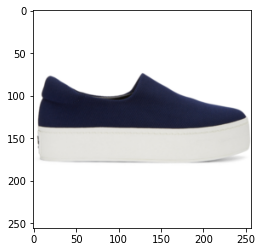

In [ ]:
product = dataset.get_product_by_id(queries_ids[q])
print("Target:")
plt.imshow(product.image)

In [ ]:
queries_text[q]

'Slip-on twill platform sneakers in navy. Round toe. Padded heel collar. Textured rubber sole in white featuring rubberized logo in black at heel. Leather lining in black. Tonal stitching. Approx. 1.5" platform.'

Slip-on twill platform sneakers in navy. Round toe. Padded heel collar. Textured rubber sole in white featuring rubberized logo in black at heel. Leather lining in black. Tonal stitching. Approx. 1.5" platform.


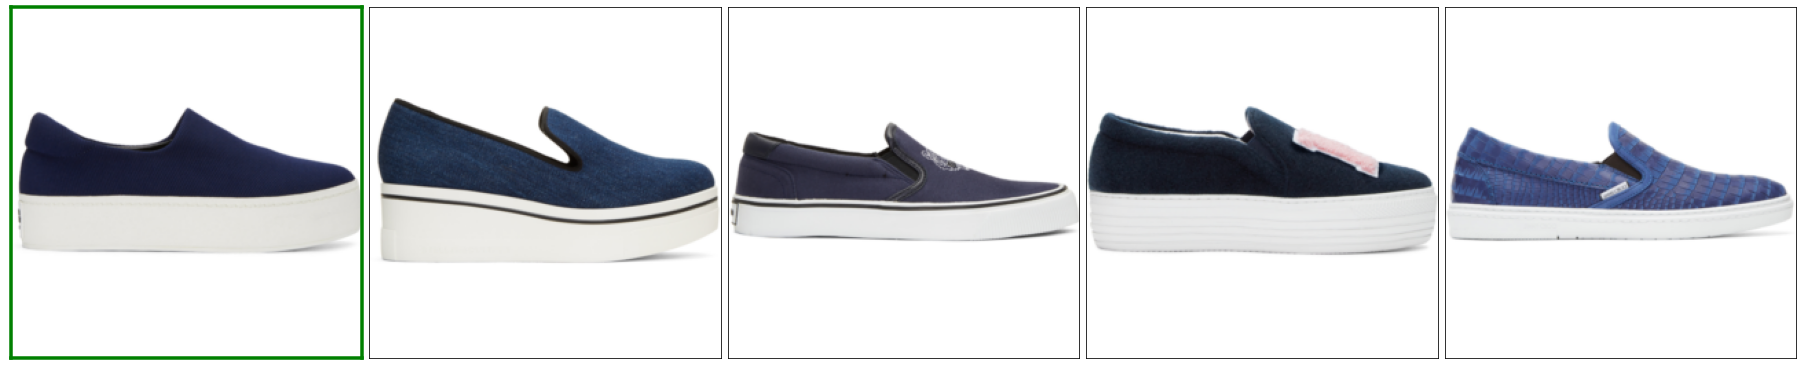

In [ ]:
print(product.caption)
see_top = 5
retrieved_ids = I[q]
# make sure a product is not repeated multiple times 
unique_retrieved_ids = list(dict.fromkeys(retrieved_ids))
retrieved = [dataset.get_product_by_id(i) for i in unique_retrieved_ids[:see_top]]
visualize_product_images(retrieved, highlight_id=product.p_id)

What accuracy can we achieve with an approximate nearest neighbor search technique? 

Lets' create an **IVF index with 100 cells**

In [ ]:
k_prime = 100 # number of voronoi cells

ivf_index = faiss.index_factory(d, f"IVF{k_prime},Flat") # IVF index with IndexFlatL2 as quantizer
# the ivf index already has the IDMap by default

ivf_index.train(image_embeddings) # train the index (i.e. subdivided the space into cells)

ivf_index.add_with_ids(image_embeddings, product_ids)

# try moving the index on GPU to speed up retrieval
try:
  res = faiss.StandardGpuResources() 
  ivf_index = faiss.index_cpu_to_gpu(res, 0, ivf_index)
except:
  print("GPU not available!")

k = 100
# SEARCH
start = time.time()
D,I = ivf_index.search(query_embeddings, k)
print(f"Result found in {time.time()-start} seconds")

rank_at_k = compute_rank_at_k(queries_ids, I, Ks)
print_result(rank_at_k)

Result found in 0.00516057014465332 seconds
Rank@1=19.0%
Rank@3=33.5%
Rank@5=38.0%
Rank@10=47.5%
Rank@30=61.5%
Rank@100=71.0%
R_Sum=270.5


We can try to improve results by increasing the `nprobe` parameter.

In [ ]:
nprobe = 3
ivf_index.nprobe = nprobe  

start = time.time()
D,I = ivf_index.search(query_embeddings, k)
print(f"Result found in {time.time()-start} seconds")

Result found in 0.006475925445556641 seconds


In [ ]:
rank_at_k = compute_rank_at_k(queries_ids, I, Ks)
print_result(rank_at_k)

Rank@1=19.5%
Rank@3=34.5%
Rank@5=43.5%
Rank@10=55.00000000000001%
Rank@30=75.0%
Rank@100=85.0%
R_Sum=312.50000000000006


## Exercise 2

Create a PCA index wich reduces embedding dimension from 768 to 32 and:
- Measure the time it requires to perform retrieval
- Compute its Rank@K metrics


**note**: make sure to create the index using the `faiss.index_factory(d, "IDMap, PCA32, Flat")` so that you can add image embeddings with the `add_with_ids` method


In [ ]:
#@title Solution

pca_index = faiss.index_factory(d, "IDMap,PCA32,Flat")
pca_index.train(image_embeddings)
pca_index.add_with_ids(image_embeddings, product_ids)

# try moving the index on GPU to speed up retrieval
try:
  res = faiss.StandardGpuResources() 
  pca_index = faiss.index_cpu_to_gpu(res, 0, pca_index)
  print("Index moved on GPU!")
except:
  print("GPU not available!")

start = time.time()
D,I = pca_index.search(query_embeddings, k)
print(f"Result found in {time.time()-start} seconds")

rank_at_k = compute_rank_at_k(queries_ids, I, Ks)
print_result(rank_at_k)

Index moved on GPU!
Result found in 0.0038802623748779297 seconds
Rank@1=21.0%
Rank@3=37.5%
Rank@5=45.5%
Rank@10=55.50000000000001%
Rank@30=75.5%
Rank@100=90.5%
R_Sum=325.5


## Compare Multiple Indices by Speed and Accuracy (Optional)

In [ ]:
res = faiss.StandardGpuResources()
index_types = ["IDMap,Flat", 
               "IDMap,PCA32,Flat",
               "IVF128,Flat","PCA32,IVF128,Flat",
               "IVF256,Flat","PCA32,IVF256,Flat",
               "IVF512,Flat","PCA32,IVF512,Flat",
               "IVF1024,Flat", "PCA32,IVF1024,Flat"]

k = 100 # find top-100 results
nprobes = 3 # visit 3 cells when using IVF indices
num_iterations = 10 # we run 10 searches for each index and take the average
indices_results = {}

use_gpu = False # change to True if you want to test results with gpu

for index_type in index_types:
    print(f"=== TESING {index_type} ===")
    index = faiss.index_factory(d, index_type)
    index.nprobe = nprobe

    if use_gpu:
      try:
        index = faiss.index_cpu_to_gpu(res, 0, index)
      except:
        print("GPU not available!")

    if not index.is_trained:
      index.train(image_embeddings)

    index.add_with_ids(image_embeddings, product_ids)

    retrieval_time =  avg_search_time(index, query_embeddings, k, num_iterations=num_iterations)
    _, I = index.search(query_embeddings, k)     # actual search
    
    rank_at_k = compute_rank_at_k(queries_ids, I, Ks)
    sum_R = r_sum(rank_at_k)
    indices_results[index_type] = (retrieval_time, sum_R*100)

=== TESING IDMap,Flat ===


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


=== TESING IDMap,PCA32,Flat ===


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


=== TESING IVF128,Flat ===


100%|██████████| 10/10 [00:01<00:00,  9.00it/s]


=== TESING PCA32,IVF128,Flat ===


100%|██████████| 10/10 [00:00<00:00, 207.34it/s]


=== TESING IVF256,Flat ===


100%|██████████| 10/10 [00:00<00:00, 17.11it/s]


=== TESING PCA32,IVF256,Flat ===


100%|██████████| 10/10 [00:00<00:00, 101.79it/s]


=== TESING IVF512,Flat ===


100%|██████████| 10/10 [00:00<00:00, 17.82it/s]


=== TESING PCA32,IVF512,Flat ===


100%|██████████| 10/10 [00:00<00:00, 324.53it/s]


=== TESING IVF1024,Flat ===


100%|██████████| 10/10 [00:00<00:00, 42.43it/s]


=== TESING PCA32,IVF1024,Flat ===


100%|██████████| 10/10 [00:00<00:00, 324.57it/s]


Text(0.5, 1.0, 'Indices Comparison')

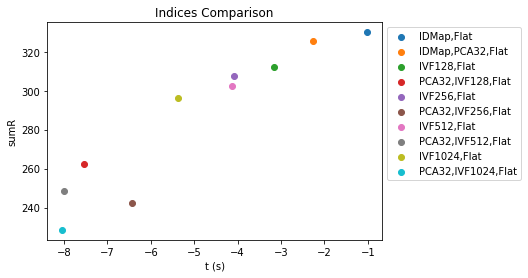

In [ ]:
for index_name ,v in indices_results.items():
  plt.scatter(math.log2(v[0]), v[1], label=index_name)

plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel("t (s)")
plt.ylabel("sumR")
plt.title("Indices Comparison")